In [1]:
import sys
sys.path.append('/lmh_data/work/sclab/train/')

import math
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import pyBigWig
from scipy import stats

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

from util import array2mat, mat2array

In [2]:
control_evals = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)
AD_evals = np.load('/lmh_data/data/sclab/sclab/AD/eval_dataset.npy', allow_pickle=True)

gene_names = ['SLC1A2', 'SLC1A3', 'GPM6A']
control_preds, AD_preds = dict(), dict()
for gene_name in gene_names:
    control_preds[gene_name] = np.load(
        '/lmh_data/data/sclab/sclab/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)
    AD_preds[gene_name] = np.load(
        '/lmh_data/data/sclab/sclab/AD/tmp/{}/evaluate.npy'.format(gene_name), allow_pickle=True)

In [36]:
def show_by_cell_type(evals, preds, cell_type, Diagnosis=None, ignore_diag=True):
    _pred, _tar = None, None
    num = 0
    for i in range(len(preds)):
        pred = preds[i]
        if evals[i]['cell_type'] != cell_type:
            continue
        if Diagnosis and evals[i]['Diagnosis'] != Diagnosis:
            continue
        num += 1
        _predict, _target = pred['predict'].copy(), pred['target'].copy()
        _predict += abs(_predict.min())
        if ignore_diag:
            _predict = array2mat(_predict)
            np.fill_diagonal(_predict, 0)
            _predict = mat2array(_predict)
        _predict /= _predict.sum()
        if _pred is None:
            _pred, _tar = _predict, _target
        else:
            _pred += _predict
            _tar += _target
    return _pred/num, _tar/num

In [37]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def colorbar_triangle(axm,im,ymax):
    height="2%"
    width="10%"
    if ymax!=None:
        height="6%"
    axins1 = inset_axes(axm, width=width, height=height, loc=4, bbox_to_anchor=(-0.1, 0.7, 1.2, 2.9), bbox_transform=axm.transAxes,)
    cbar=plt.colorbar(im, cax=axins1, orientation='horizontal')
    cbar.ax.xaxis.tick_top()
    cbar.ax.spines['top'].set_color('none')
    cbar.ax.spines['right'].set_color('none')
    cbar.ax.spines['bottom'].set_color('none')
    cbar.ax.spines['left'].set_color('none')


def heatmap_triangle(
    axes, mat, matBalance=False,
    width=6, height=3, norm=None, cmap=mpl.cm.YlGnBu, showXticks=True, title=None, ymax=None, logData=False
):
    if logData == True:
        mat = np.log2(mat)

    N = mat.shape[1]

    # Transformation matrix for rotating the heatmap.
    A = np.array([(y, x) for x in range(N, -1, -1) for y in range(N + 1)])
    t = np.array([[1,0.5], [-1,0.5]])
    A = np.dot(A, t)

    C = np.triu(mat)

    # This MUST be before the call to pl.pcolormesh() to align properly.
    #axes.set_xticks([])
    axes.set_yticks([])

    # Plot the correlation heatmap triangle.
    X = A[:, 1].reshape(N + 1, N + 1)
    Y = A[:, 0].reshape(N + 1, N + 1)

    caxes = axes.pcolormesh(X, Y, np.flipud(C), axes=axes, norm=norm, cmap=cmap, edgecolor='none', snap=True, linewidth=.001)

    # Remove the ticks and reset the x limit.

    axes.set_ylim(bottom=0)
    axes.set_xlim(left=0)
    if ymax != None:
        axes.set_ylim(top=ymax)
    axes.set_title(title)
    
    #set_heatmap_ticks(axes)
    
    axes.axis("off")
    colorbar_triangle(axes, caxes, ymax)
    
def plot_diag(ax, diag, ylabel, resolution=10000, yminx=5, ymaxx=95, rotation=0, fl='%0.2f', color='#464451'):
    ax.tick_params(bottom=False, top=False, left=True, right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = len(diag)

    width = 1
    ax.bar(x=range(0,x), height=diag, width=1, bottom=[0]*(x), color=color, align="edge", edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(diag, yminx)
    ymax = np.percentile(diag, ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')
    
def plot_gene(ax, gene_bed, chrom, start, end, line=1, gene_col=[], fontszie=5):
    gene_bed = gene_bed[gene_bed['chrom']==chrom]
    gene_bed_plot = gene_bed[((gene_bed['start'] >= start) & (gene_bed['start'] <= end)) | ((gene_bed['end'] >= start) & (gene_bed['end'] <= end))]
    gene_bed_plot = gene_bed_plot.sort_values(by='end')
    line = max(line, gene_bed_plot.shape[0])
    
    plot_gene_num = gene_bed_plot.shape[0]
    if line == 1:
        for i,row in gene_bed_plot.iterrows():
            ax.plot((row['start'], row['end']), (0.5, 0.5), color='b')
            starts = row["blockStarts"]
            widths = row["blockSizes"]
            
            ax.bar(x=starts, height=1, width=widths, bottom=0, \
                   edgecolor='black', linewidth=0, align='edge', color='b', ecolor=None)
    else:
        ii = 0
        for i,row in gene_bed_plot.iterrows():
            col = "#3366CC"
            text_col = '#3366CC'
            
            if row["strand"] == "-":
                col = "#EECFA1"
                text_col = '#EECFA1'
            
            #text_col = col
            plot_y = ii%line
            
            if i in gene_col:
                col = "red"
                text_col = "red"
            
            ax.plot((row['start'], row['end']), (plot_y + 0.5, plot_y+0.5), color=col)
            starts = row["blockStarts"]
            widths = row["blockSizes"]
            
            ax.bar(x=starts, height=0.8, width=widths, bottom=plot_y+0.1, \
                   edgecolor=col, linewidth=0.3, align='edge', color=col)
            
            if row['start'] < start:
                    row['start'] = start
            if row['end'] > end:
                    row['end'] = end
            
#             if (gene_bed_plot.iloc[-1]['name'] == i) or (gene_bed_plot.iloc[-2]['name'] == i) or (gene_bed_plot.iloc[-3]['name'] == i):
#                 ax.text(row['start'], plot_y + 0.5, i + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)
#             else:
#                 ax.text(row['end'], plot_y + 0.5, "  " + i, ha='left', va='center',color=text_col, fontsize=fontszie)
            ax.text(row['start'], plot_y + 0.5, i + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)

            ii+=1
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
    if plot_gene_num < line:
        ax.spines['bottom'].set_position(('data', plot_gene_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")
    
def plot_bwTrack(ax, bw, ylabel, chrom, start, end, resolution=20000 , yminx=5, ymaxx=95,rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    plot_list = bw.stats(chrom, start, end, type="mean", nBins=x)
    plot_list = [0 if v is None else v  for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')
    
def pre_track(predict_array):
    fig = plt.figure(figsize=(20, 9), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(9, 1)
    ax0 = fig.add_subplot(gs[0:8, 0], facecolor='white')

    _test = array2mat(predict_array)
    _test += abs(_test.min())
    row, col = np.diag_indices_from(_test)
    _diag = _test[row,col].copy()
    
    _test[row,col] = 0
    heatmap_triangle(ax0, _test, width=6, height=2.7, logData=False)

    plt.show()

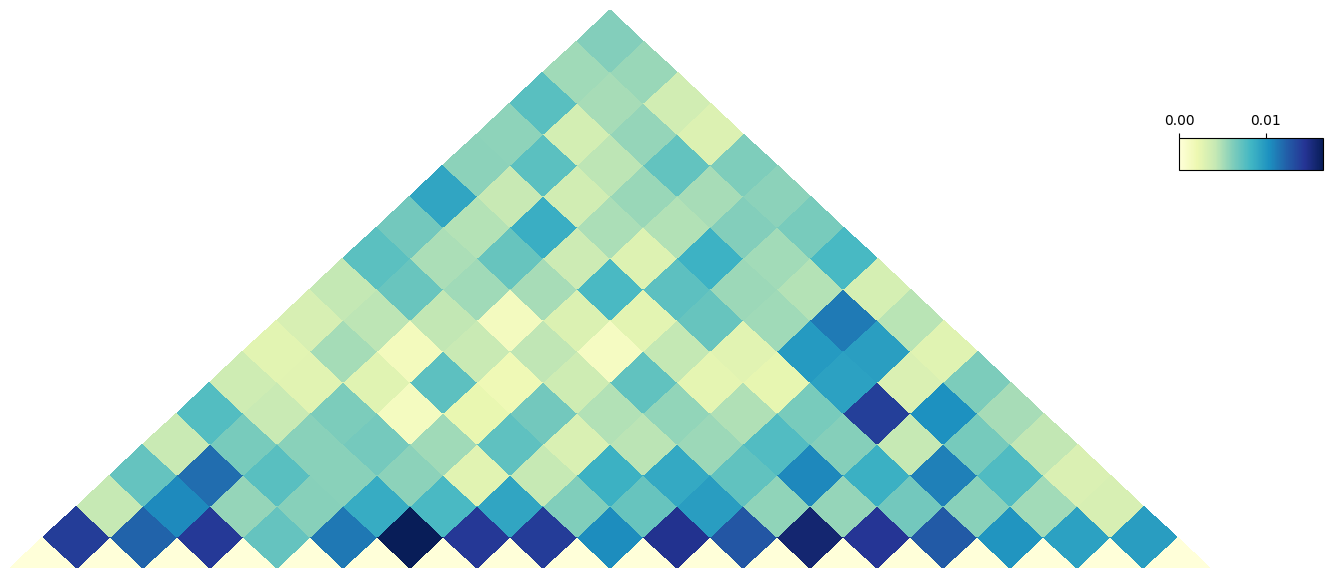

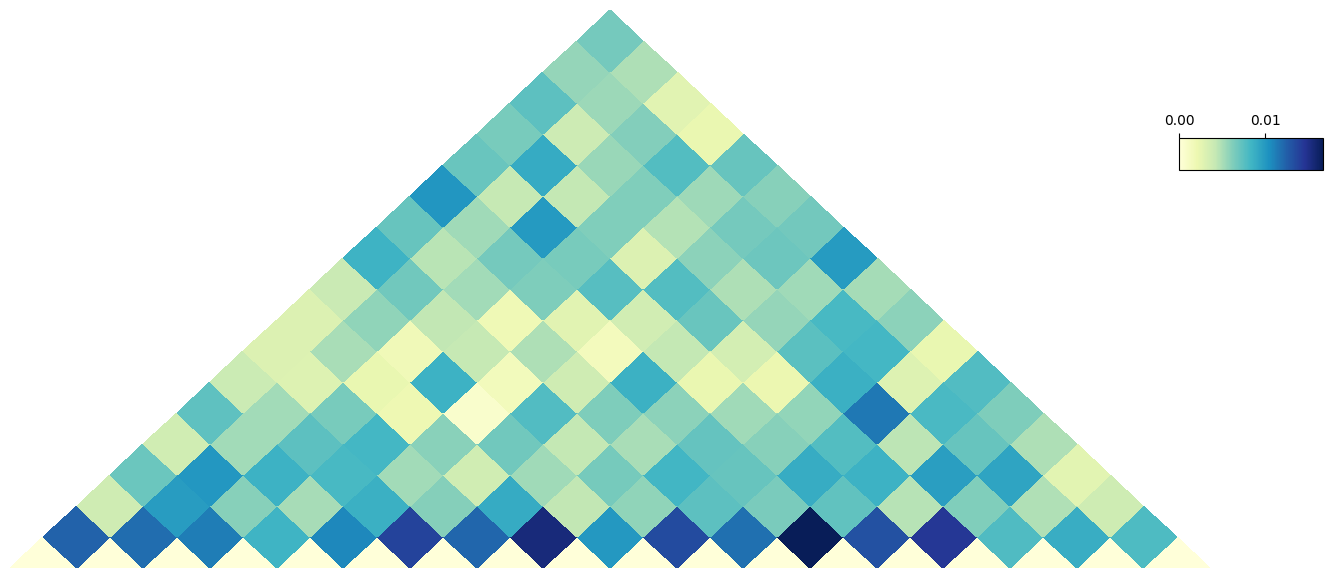

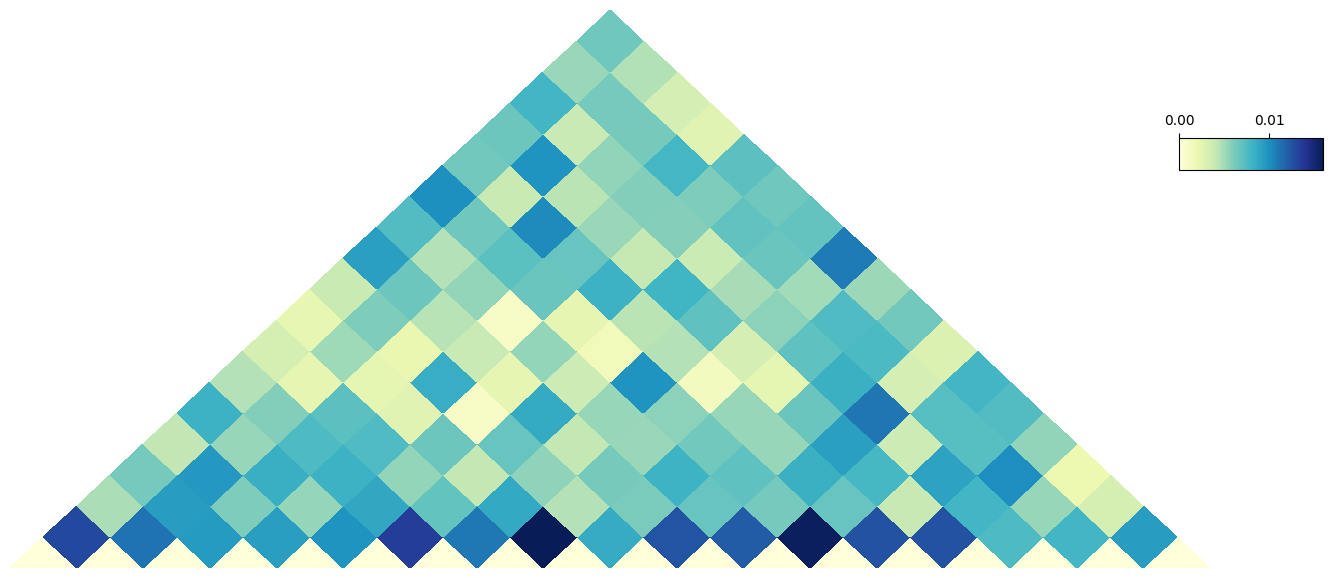

In [38]:
pre_track(show_by_cell_type(control_evals, control_preds['SLC1A2'], 'Astro')[0])
pre_track(show_by_cell_type(AD_evals, AD_preds['SLC1A2'], 'Astro', 'control')[0])
pre_track(show_by_cell_type(AD_evals, AD_preds['SLC1A2'], 'Astro', 'AD')[0])

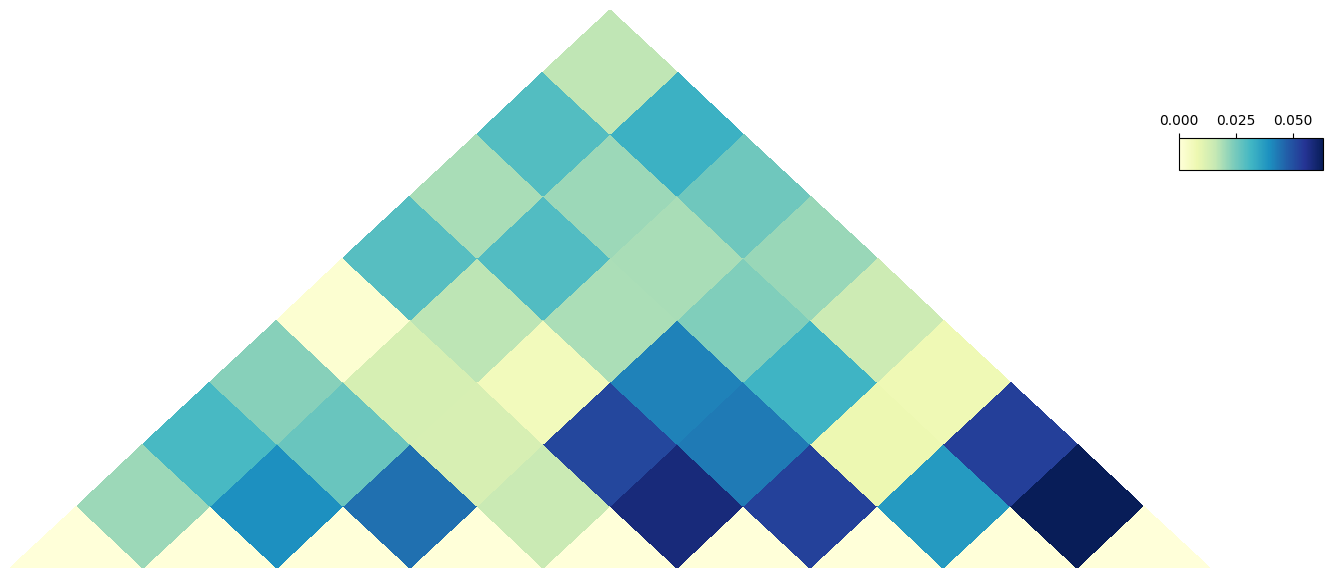

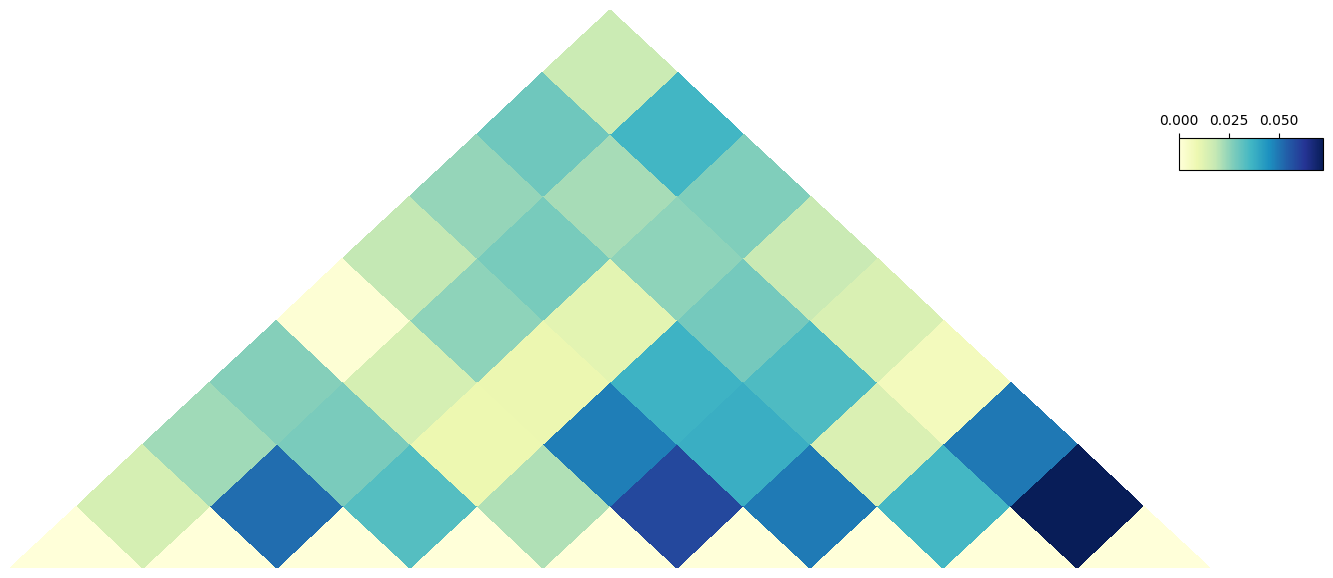

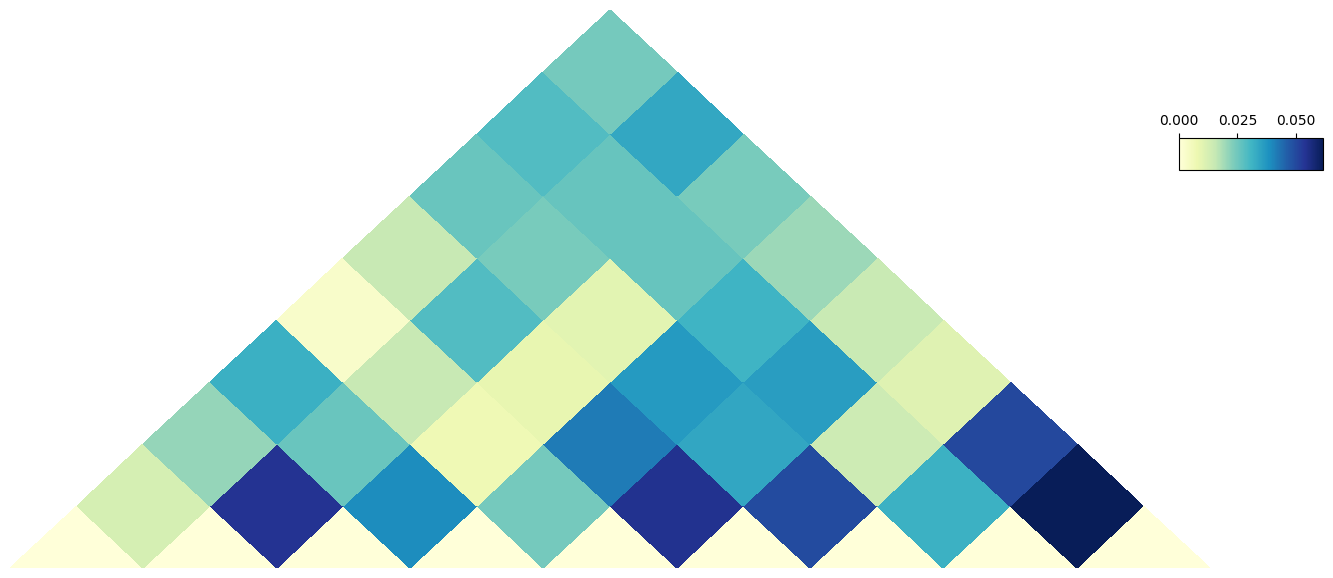

In [39]:
pre_track(show_by_cell_type(control_evals, control_preds['SLC1A3'], 'Astro')[0])
pre_track(show_by_cell_type(AD_evals, AD_preds['SLC1A3'], 'Astro', 'control')[0])
pre_track(show_by_cell_type(AD_evals, AD_preds['SLC1A3'], 'Astro', 'AD')[0])

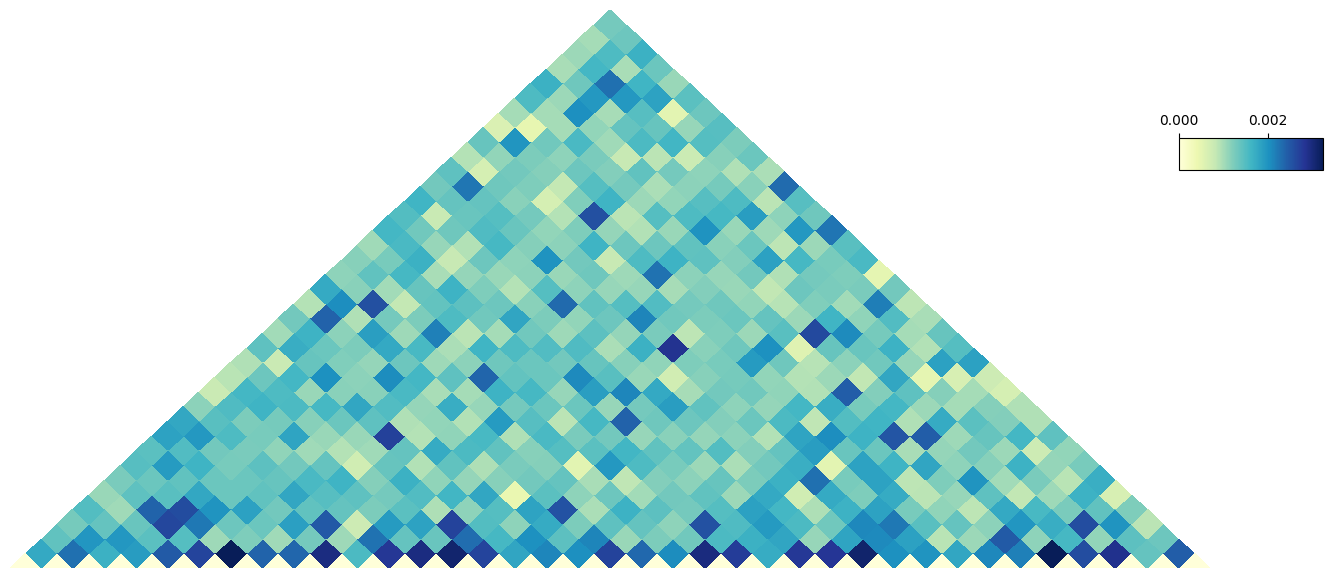

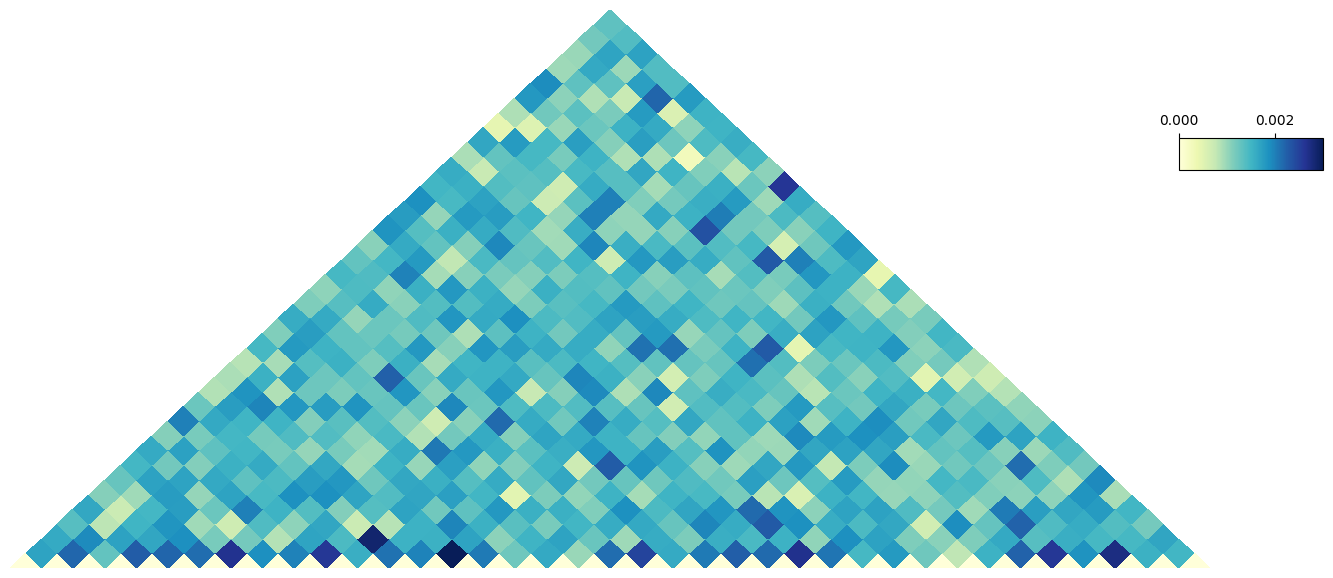

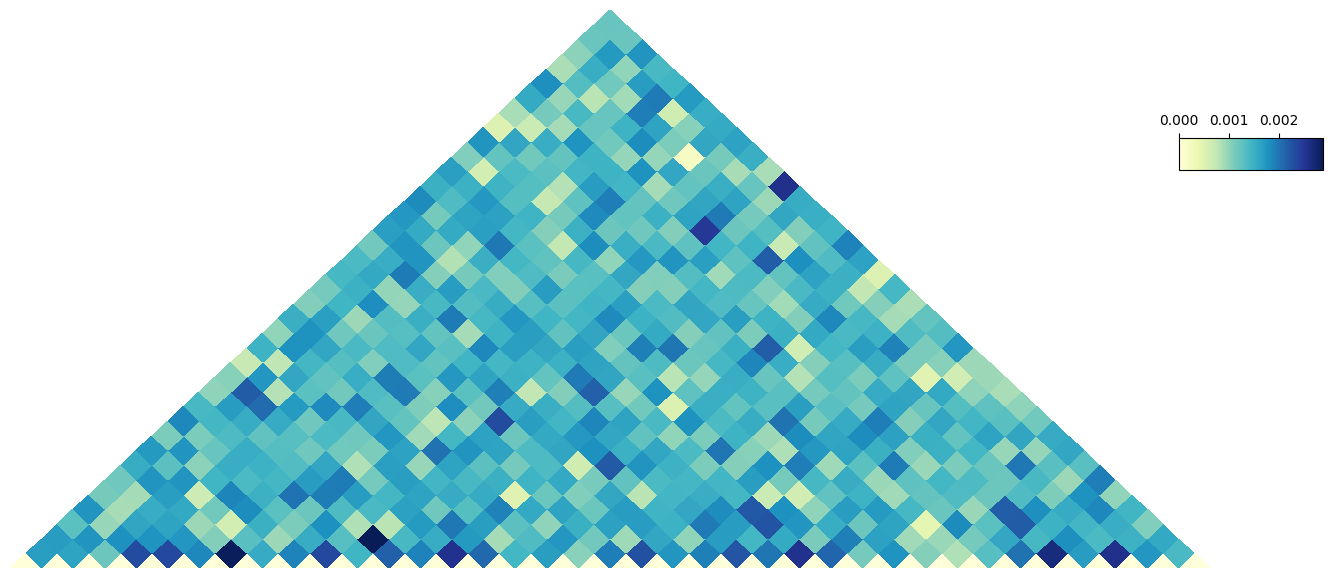

In [40]:
pre_track(show_by_cell_type(control_evals, control_preds['GPM6A'], 'Astro')[0])
pre_track(show_by_cell_type(AD_evals, AD_preds['GPM6A'], 'Astro', 'control')[0])
pre_track(show_by_cell_type(AD_evals, AD_preds['GPM6A'], 'Astro', 'AD')[0])

In [8]:
v19_anno = pd.read_csv('/lmh_data/data/sclab/public/gencode.v19.annotation.gtf',
                       header=None, sep='\t', skiprows=[i for i in range(5)], usecols=[0, 2, 3, 4, 6, 8], names=[
                           'chrom', 'type', 'start', 'end', 'strand', 'info'
                       ])
v19_anno['gene_name'] = v19_anno['info'].str.extract(r'(gene_name ")(\S*)(")')[1]
v19_anno['transcript_name'] = v19_anno['info'].str.extract(r'(transcript_name ")(\S*)(")')[1]
v19_anno

,chrom,type,start,end,strand,info,gene_name,transcript_name
0,chr1,gene,11869,14412,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1
1,chr1,transcript,11869,14409,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
2,chr1,exon,11869,12227,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
3,chr1,exon,12613,12721,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
4,chr1,exon,13221,14409,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
...,...,...,...,...,...,...,...,...
2619439,chrM,transcript,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,MT-TT-201
2619440,chrM,exon,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,MT-TT-201
2619441,chrM,gene,15956,16023,-,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",MT-TP,MT-TP
2619442,chrM,transcript,15956,16023,-,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",MT-TP,MT-TP-201


In [9]:
transcript_info = v19_anno[v19_anno['type']=='transcript'].copy()
transcript_info = transcript_info.set_index('transcript_name')
transcript_info = transcript_info.drop(labels='info', axis=1)
transcript_info = transcript_info.drop(labels='type', axis=1)

exons = v19_anno[(v19_anno['type']=='exon')&(v19_anno['transcript_name'].isin(transcript_info.index))].copy()
exons['blockSizes'] = exons['end'] - exons['start']
exons['blockStarts'] = exons['start']
exons_group = exons.groupby("transcript_name")
transcript_info['blockCount'] = exons_group['blockStarts'].count()
transcript_info['blockSizes'] = exons_group['blockSizes'].apply(list)
transcript_info['blockStarts'] = exons_group['blockStarts'].apply(list)
transcript_info

,chrom,start,end,strand,gene_name,blockCount,blockSizes,blockStarts
transcript_name,,,,,,,,
DDX11L1-002,chr1,11869,14409,+,DDX11L1,3,"[358, 108, 1188]","[11869, 12613, 13221]"
DDX11L1-201,chr1,11872,14412,+,DDX11L1,3,"[355, 108, 1187]","[11872, 12613, 13225]"
DDX11L1-202,chr1,11874,14409,+,DDX11L1,4,"[353, 126, 252, 748]","[11874, 12595, 13403, 13661]"
DDX11L1-001,chr1,12010,13670,+,DDX11L1,6,"[47, 48, 84, 77, 153, 217]","[12010, 12179, 12613, 12975, 13221, 13453]"
WASH7P-202,chr1,14363,29370,-,WASH7P,12,"[49, 153, 111, 146, 140, 131, 201, 158, 43, 10...","[29321, 24738, 18268, 17915, 17602, 17233, 168..."
...,...,...,...,...,...,...,...,...
MT-ND6-201,chrM,14149,14673,-,MT-ND6,1,[524],[14149]
MT-TE-201,chrM,14674,14742,-,MT-TE,1,[68],[14674]
MT-CYB-201,chrM,14747,15887,+,MT-CYB,1,[1140],[14747]


In [10]:
ATAC = sc.read('/lmh_data/data/sclab/syn22092838/snATAC_counts.mtx')
peaks = pd.read_csv('/lmh_data/data/sclab/syn22092838/peaks.csv', header=None)
snATAC_metadata = pd.read_csv('/lmh_data/data/sclab/syn22092838/snATAC_metadta.csv', index_col=0)

ATAC.obs_names = peaks.values.reshape(-1)
ATAC.var = snATAC_metadata
ATAC = ATAC.T

ATAC

AnnData object with n_obs × n_vars = 132623 × 227255
    obs: 'Sample.ID', 'Batch', 'Sex', 'Age', 'Diagnosis', 'UMAP_1', 'UMAP_2', 'cluster', 'celltype'

In [11]:
ATAC.var['chr'], ATAC.var['start'], ATAC.var['end'] = ATAC.var_names.str.split(':|-').str
ATAC.var['start'], ATAC.var['end'] = ATAC.var['start'].apply(int), ATAC.var['end'].apply(int)
ATAC.var

/tmp/ipykernel_73635/3785389900.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  ATAC.var['chr'], ATAC.var['start'], ATAC.var['end'] = ATAC.var_names.str.split(':|-').str


,chr,start,end
chr1:190840-191925,chr1,190840,191925
chr1:629708-630559,chr1,629708,630559
chr1:631640-631957,chr1,631640,631957
chr1:632495-633098,chr1,632495,633098
chr1:633741-634673,chr1,633741,634673
...,...,...,...
chrY:56867602-56868075,chrY,56867602,56868075
chrY:56868639-56874760,chrY,56868639,56874760
chrY:56876006-56876385,chrY,56876006,56876385
chrY:56877531-56877939,chrY,56877531,56877939


In [12]:
ATAC.obs.celltype = ATAC.obs.celltype.astype('category')
ATAC.obs.celltype = ATAC.obs.celltype.cat.rename_categories({'ASC': 'Astro'})
ATAC.obs

,Sample.ID,Batch,Sex,Age,Diagnosis,UMAP_1,UMAP_2,cluster,celltype
AAACGAAAGAAACGCC-13,Sample-96,1,M,79,Control,4.653650,-2.973710,ODC.f,ODC
AAACGAAAGAAATGGG-11,Sample-101,2,F,74,Control,6.781233,-2.420259,ODC.k,ODC
AAACGAAAGAAATGGG-5,Sample-37,3,F,87,AD,-2.631755,-6.038205,PER.END.a,PER.END
AAACGAAAGAAATTCG-13,Sample-96,1,M,79,Control,-7.145253,2.478923,EX.b,EX
AAACGAAAGAACGACC-8,Sample-43,1,F,90,AD,3.383448,0.103595,ODC.a,ODC
...,...,...,...,...,...,...,...,...,...
TTTGTGTTCTTCATAC-13,Sample-96,1,M,79,Control,6.218156,-2.558979,ODC.j,ODC
TTTGTGTTCTTCCACG-13,Sample-96,1,M,79,Control,4.888400,-5.111481,ODC.e,ODC
TTTGTGTTCTTCCACG-7,Sample-46,2,M,90,AD,6.508900,0.919111,ODC.b,ODC
TTTGTGTTCTTGCGCT-1,Sample-82,2,M,79,Control,5.296374,-4.003198,ODC.h,ODC


In [13]:
H3K27ac = pyBigWig.open('/lmh_data/data/sclab/source/Astro/impute_BSS00089_H3K27ac.bigWig')

def plot_bwTrack(ax, bw, ylabel, chrom, start, end, resolution=20000 , yminx=5, ymaxx=95,rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    plot_list = bw.stats(chrom, start, end, type="mean", nBins=x)
    plot_list = [0 if v is None else v  for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')

In [41]:
def plot_ATAC_peak(
    ax, adata, ylabel, chrom, start, end, resolution=20000, yminx=5, ymaxx=95,rotation=0, fl='%0.2f', color='#464451'
):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    _adata = adata[:,adata.var[(adata.var['start']>=start)&(adata.var['start']>=start)&(ATAC.var['start']<end)].index]
    _adata1 = _adata[_adata.obs[ATAC.obs['Diagnosis']=='Control'].index]
    _adata2 = _adata[_adata.obs[ATAC.obs['Diagnosis']=='AD'].index]

    _adata1 = anndata.AnnData(X=np.expand_dims(_adata1.X.toarray().mean(axis=0), axis=0), var=_adata1.var)
    _adata2 = anndata.AnnData(X=np.expand_dims(_adata2.X.toarray().mean(axis=0), axis=0), var=_adata2.var)
    plot_list = []
    for i in range(start, end, resolution):
        _peak1 = _adata1[:, _adata1.var[(_adata1.var['start']>=i)&(_adata1.var['start']<i+10000)].index].X.mean()
        _peak2 = _adata2[:, _adata2.var[(_adata2.var['start']>=i)&(_adata2.var['start']<i+10000)].index].X.mean()
        plot_list.append(float(_peak1) - float(_peak2))
    plot_list = [0 if v is None or np.isnan(v) else v for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')

def pre_track(predict_array, gene_name, cell_type):
    fig = plt.figure(figsize=(20, 9), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(15, 1)
    ax0 = fig.add_subplot(gs[0:8, 0], facecolor='white')
    ax1 = fig.add_subplot(gs[8, 0], facecolor='white')
    ax2 = fig.add_subplot(gs[9, 0], facecolor='white')
    ax3 = fig.add_subplot(gs[10:15, 0], facecolor='white')

    _test = array2mat(predict_array)
    heatmap_triangle(ax0, _test, width=6, height=2.7, norm=colors.CenteredNorm(), cmap='RdBu_r', logData=False)
    
    _gene = v19_anno[(v19_anno['gene_name']==gene_name)&(v19_anno['type']=='gene')]
    chrom, start, end = _gene['chrom'].values[0], _gene['start'].values[0], _gene['end'].values[0]
    if _gene['strand'].values[0] == '+':
        start -= 5000
    else:
        end += 5000
    start, end = int(start/10000)*10000, int(end/10000)*10000 + 10000

    plot_ATAC_peak(ax1, ATAC[ATAC.obs[ATAC.obs['celltype']==cell_type].index],
                   "ATAC(control-AD)", chrom, start, end, resolution=10000,
                   yminx=0, ymaxx=100, rotation=0, fl='%0.2f', color='#62D6E3')
    plot_bwTrack(ax2, H3K27ac, "H3K27ac(control)", chrom, start, end, resolution=10000, 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_gene(ax3, transcript_info, chrom, start, end, line=10, gene_col=[], fontszie=8)
    
    plt.show()

/tmp/ipykernel_73635/3132398235.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _adata1 = _adata[_adata.obs[ATAC.obs['Diagnosis']=='Control'].index]
/tmp/ipykernel_73635/3132398235.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _adata2 = _adata[_adata.obs[ATAC.obs['Diagnosis']=='AD'].index]


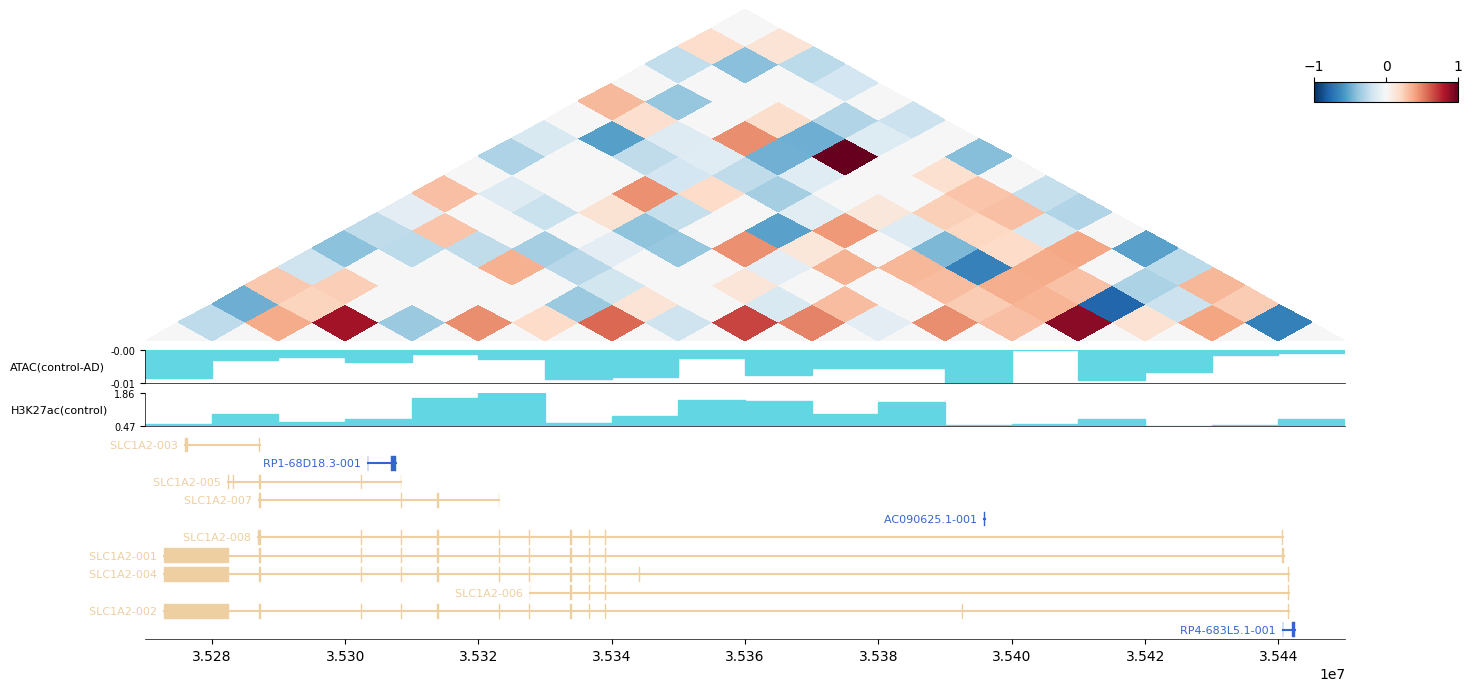

In [42]:
gene_name, cell_type = 'SLC1A2', 'Astro'
control_control = show_by_cell_type(control_evals, control_preds[gene_name], cell_type)[0]
AD_control = show_by_cell_type(AD_evals, AD_preds[gene_name], cell_type, 'control')[0]
AD_AD = show_by_cell_type(AD_evals, AD_preds[gene_name], cell_type, 'AD')[0]

_tmp = AD_control - AD_AD
_tmp /= _tmp.max()
_tmp[(_tmp<0.1)&(_tmp>-0.1)] = 0
pre_track(_tmp, gene_name, cell_type)

In [43]:
def interaction_relevance(evals, preds, cell_type, gene_name, bin1, bin2):
    x1, x2, y1, y2 = [], [], [], []
    for i in range(len(preds)):
        pred = array2mat(preds[i]['predict'])
        pred += abs(pred.min())
        pred /= pred.sum()
        if evals[i]['cell_type'] != cell_type:
            continue

        x = evals[i]['scRNA'][np.where(evals[i]['scRNA_head']==gene_name)[0][0]]
        y = pred[bin1, bin2]
        if x > 100:
            continue
        if evals[i]['Diagnosis'] == 'control':
            x1.append(x)
            y1.append(y)
        elif evals[i]['Diagnosis'] == 'AD':
            x2.append(x)
            y2.append(y)

    # 使用GridSpec创建网格并加入子图表
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    ax_y = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    ax_x = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    # 在主图表中绘制散点图
#     main_ax.plot(x, y, 'ok', markersize=3, alpha=0.2)
    main_ax.scatter(x1, y1, label='control')
    main_ax.scatter(x2, y2, label='AD')

    # 分别在x轴和y轴方向绘制直方图
#     x_hist.hist(x1, 40, histtype='stepfilled', orientation='vertical', color='gray')
    sns.kdeplot(x1, ax=ax_x)
    sns.kdeplot(x2, ax=ax_x)
    ax_x.invert_yaxis() # x轴方向（右下）直方图倒转y轴方向

#     y_hist.hist(y1, 40, histtype='stepfilled', orientation='horizontal', color='gray')
    sns.kdeplot(y=y1, ax=ax_y)
    sns.kdeplot(y=y2, ax=ax_y)
    ax_y.invert_xaxis() # y轴方向（左上）直方图倒转x轴方向

    plt.show()

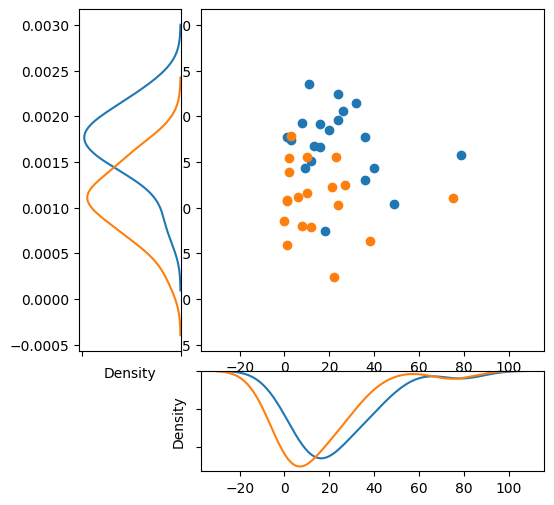

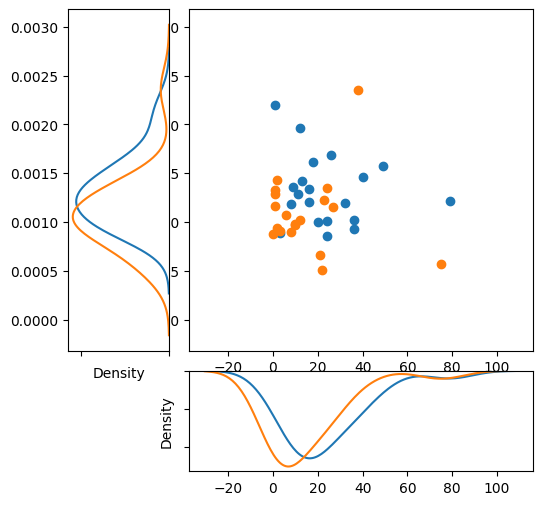

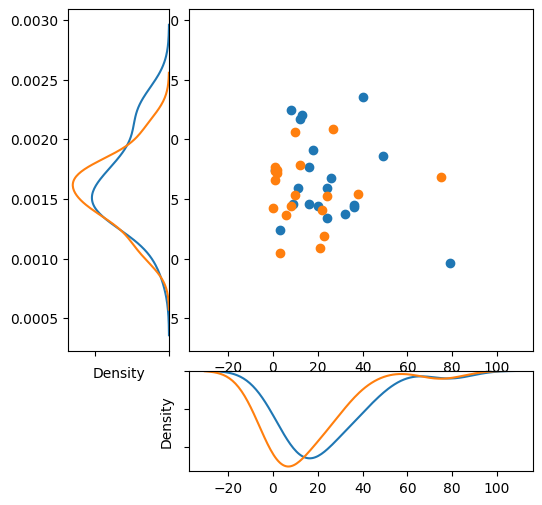

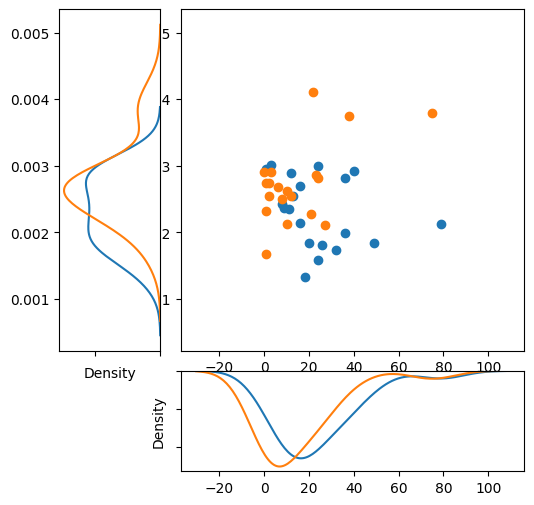

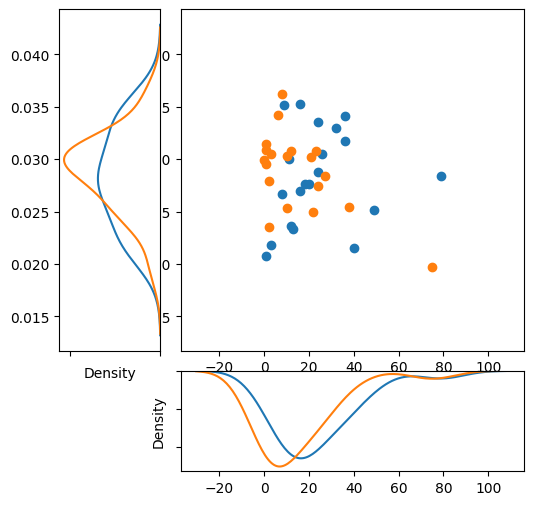

In [44]:
gene_name, cell_type = 'SLC1A2', 'Astro'
interaction_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 5, 15)
interaction_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 11, 15)
interaction_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 0, 16)
interaction_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 16, 17)
interaction_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 17, 17)

In [45]:
def loop_relevance(evals, preds, cell_type, gene_name, bin1, bin2):
    def find_interaction(mat):
        results = []
        for i in range(mat.shape[0]):
            for j in range(i+1, mat.shape[1]):
                i_min, i_max = max(0, i-1), min(mat.shape[0]-1, i+1)
                j_min, j_max = max(i+1, j-1), min(mat.shape[1]-1, j+1)
                if mat[i, j] >= mat[i_min, j] and mat[i, j] >= mat[i_max, j]:
                    if mat[i, j] >= mat[i, j_min] and mat[i, j] >= mat[i, j_max]:
                        results.append((i, j))
        return results
    
    control_nums, AD_nums = 0, 0
    for i in range(len(preds)):
        pred = array2mat(preds[i]['predict'])
        pred += abs(pred.min())
        pred /= pred.sum()
        if evals[i]['cell_type'] != cell_type:
            continue
#         import pdb; pdb.set_trace()
#         fig = plt.figure(figsize=[7, 7])
#         ax = fig.add_subplot()
#         pred = pred.copy()
#         np.fill_diagonal(pred, 0)
#         sns.heatmap(pred, cmap='RdBu_r', square=True, center=0)

        pred = pred.copy()
        np.fill_diagonal(pred, 0)
        interactions = find_interaction(pred)
        if (bin1, bin2) not in interactions:
            continue
        
        if evals[i]['Diagnosis'] == 'control':
            control_nums += 1
        elif evals[i]['Diagnosis'] == 'AD':
            AD_nums += 1
    return control_nums, AD_nums

In [46]:
gene_name, cell_type = 'SLC1A2', 'Astro'
print(loop_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 5, 15))
print(loop_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 11, 15))

(2, 0)
(0, 0)


/tmp/ipykernel_73635/3132398235.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _adata1 = _adata[_adata.obs[ATAC.obs['Diagnosis']=='Control'].index]
/tmp/ipykernel_73635/3132398235.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _adata2 = _adata[_adata.obs[ATAC.obs['Diagnosis']=='AD'].index]
/tmp/ipykernel_73635/3132398235.py:24: RuntimeWarning: Mean of empty slice.
  _peak1 = _adata1[:, _adata1.var[(_adata1.var['start']>=i)&(_adata1.var['start']<i+10000)].index].X.mean()
/root/miniconda3/envs/sclab/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_73635/3132398235.py:25: RuntimeWarning: Mean of empty slice.
  _peak2 = _adata2[:, _adata2.var[(_adata2.var['start']>=i)&(_adata2.var['start']<i+10000)].index].X.mean()


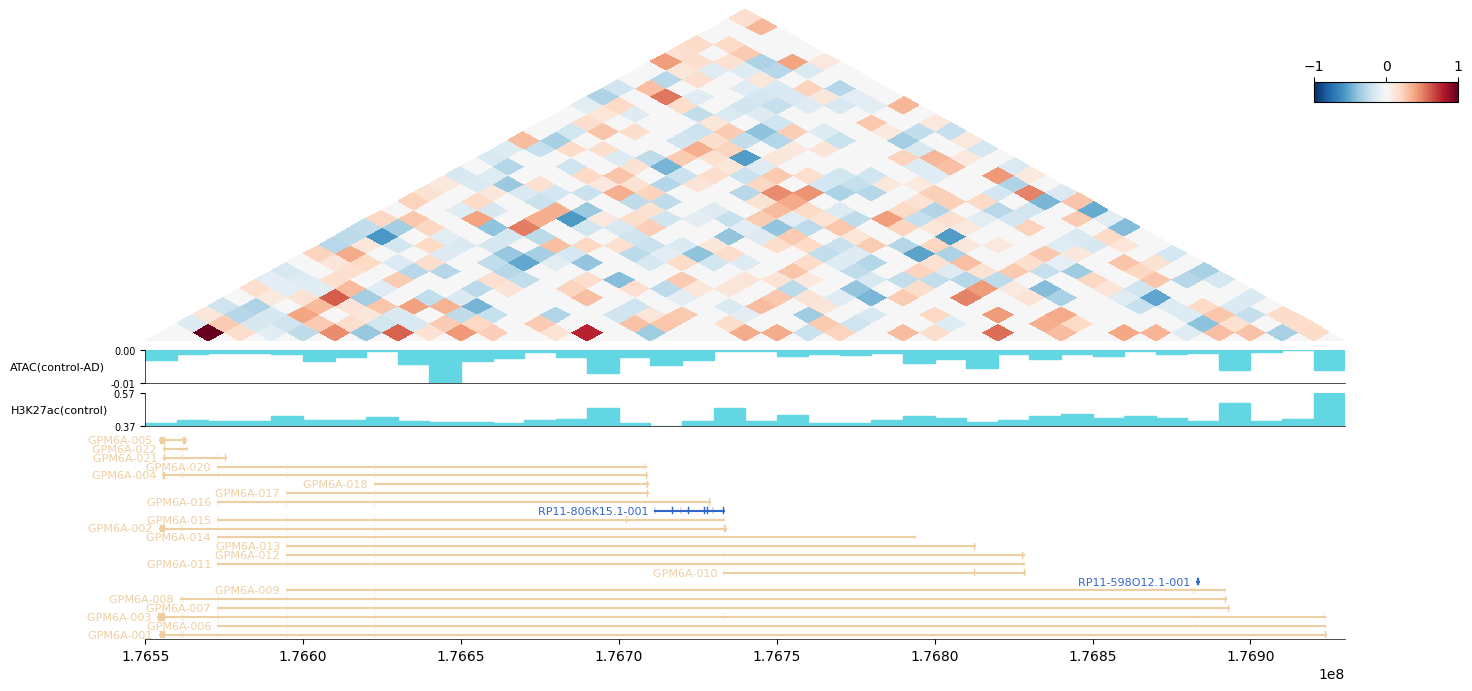

In [47]:
gene_name, cell_type = 'GPM6A', 'Astro'
control_control = show_by_cell_type(control_evals, control_preds[gene_name], cell_type)[0]
AD_control = show_by_cell_type(AD_evals, AD_preds[gene_name], cell_type, 'control')[0]
AD_AD = show_by_cell_type(AD_evals, AD_preds[gene_name], cell_type, 'AD')[0]

_tmp = AD_control - AD_AD
_tmp /= _tmp.max()
_tmp[(_tmp<0.1)&(_tmp>-0.1)] = 0
pre_track(_tmp, gene_name, cell_type)

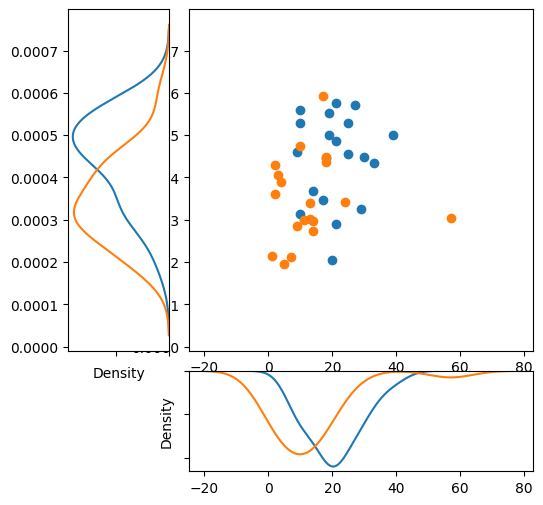

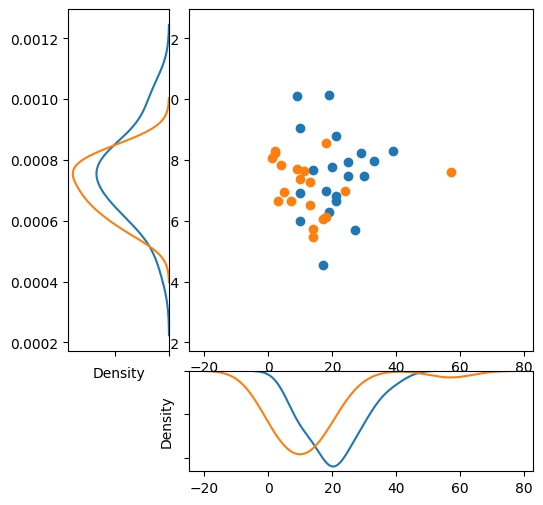

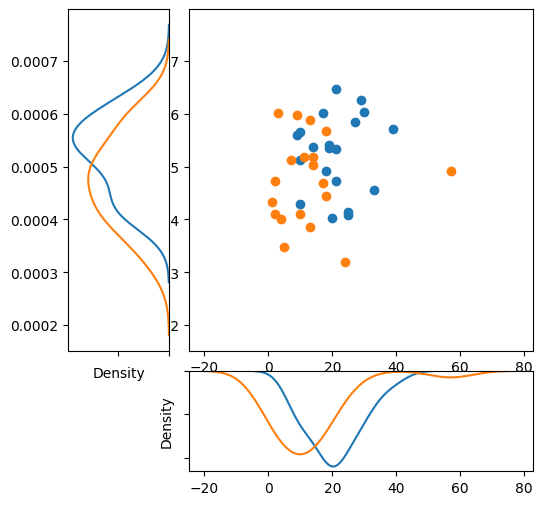

In [23]:
gene_name, cell_type = 'GPM6A', 'Astro'
interaction_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 19, 36)
interaction_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 14, 35)
interaction_relevance(AD_evals, AD_preds[gene_name], cell_type, gene_name, 1, 37)

/tmp/ipykernel_73635/3132398235.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _adata1 = _adata[_adata.obs[ATAC.obs['Diagnosis']=='Control'].index]
/tmp/ipykernel_73635/3132398235.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  _adata2 = _adata[_adata.obs[ATAC.obs['Diagnosis']=='AD'].index]


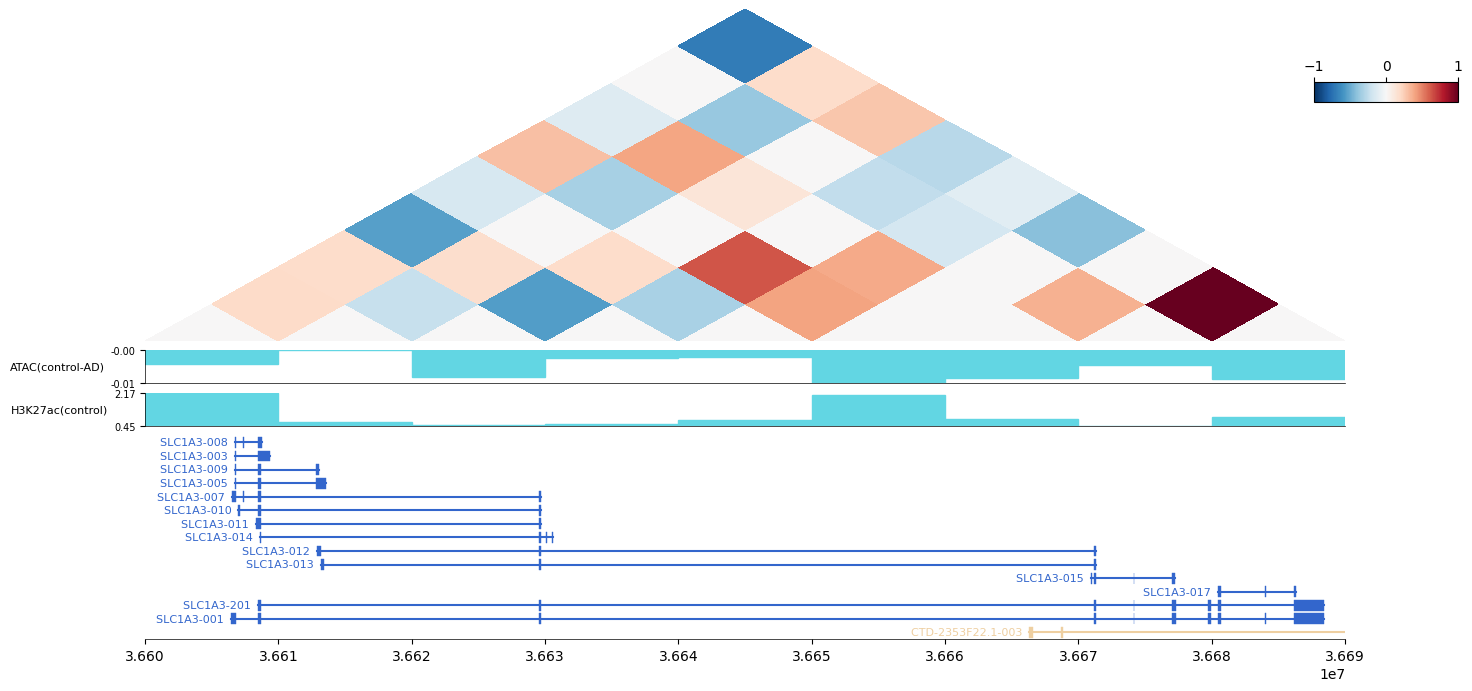

In [48]:
gene_name, cell_type = 'SLC1A3', 'Astro'
control_control = show_by_cell_type(control_evals, control_preds[gene_name], cell_type)[0]
AD_control = show_by_cell_type(AD_evals, AD_preds[gene_name], cell_type, 'control')[0]
AD_AD = show_by_cell_type(AD_evals, AD_preds[gene_name], cell_type, 'AD')[0]

_tmp = AD_control - AD_AD
_tmp /= _tmp.max()
_tmp[(_tmp<0.1)&(_tmp>-0.1)] = 0
pre_track(_tmp, gene_name, cell_type)

In [ ]:
def _draw(mat):
    fig = plt.figure(figsize=[7, 7])
    ax = fig.add_subplot()
    sns.heatmap(mat, cmap='RdBu_r', square=True, center=0)

In [ ]:
control_control = show_by_cell_type(control_evals, control_preds['SLC1A2'], 'Astro')[0]
AD_control = show_by_cell_type(AD_evals, AD_preds['SLC1A2'], 'Astro', 'control')[0]
AD_AD = show_by_cell_type(AD_evals, AD_preds['SLC1A2'], 'Astro', 'AD')[0]

_tmp = AD_control - AD_AD
_tmp[(_tmp<0.01)&(_tmp>-0.01)] = 0
_draw(array2mat(_tmp))

In [ ]:
control_control = show_by_cell_type(control_evals, control_preds['GPM6A'], 'Astro')[0]
AD_control = show_by_cell_type(AD_evals, AD_preds['GPM6A'], 'Astro', 'control')[0]
AD_AD = show_by_cell_type(AD_evals, AD_preds['GPM6A'], 'Astro', 'AD')[0]

_tmp = AD_control - AD_AD
_tmp[(_tmp<0.01)&(_tmp>-0.01)] = 0
_draw(array2mat(_tmp))

In [ ]:
from scipy import stats

control_control = show_by_cell_type(control_evals, control_preds['SLC1A3'], 'Astro')[0]
AD_control = show_by_cell_type(AD_evals, AD_preds['SLC1A3'], 'Astro', 'control')[0]
AD_AD = show_by_cell_type(AD_evals, AD_preds['SLC1A3'], 'Astro', 'AD')[0]

print(stats.spearmanr(control_control, AD_control))
print(stats.spearmanr(control_control, AD_AD))
print(stats.spearmanr(AD_control, AD_AD))